#Q1

In [ ]:
!pip install pyomo
!apt-get install -y coinor-cbc


In [ ]:
!pip install pyomo
!apt-get install -y glpk-utils

from pyomo.environ import *




In [ ]:
import pandas as pd
df = pd.read_csv("/content/kc_house_data.csv")


In [ ]:
from pyomo.environ import ConcreteModel, Var, RangeSet, Objective, ConstraintList, NonNegativeReals, minimize, SolverFactory

def lad_pyomo(df):
    model = ConcreteModel()
    n = df.shape[0]
    model.I = RangeSet(0, n-1)

    price = df["price"].values
    bedrooms = df["bedrooms"].values
    bathrooms = df["bathrooms"].values
    sqft_living = df["sqft_living"].values
    sqft_lot = df["sqft_lot"].values
    floors = df["floors"].values

    model.ep = Var(model.I, within=NonNegativeReals)
    model.em = Var(model.I, within=NonNegativeReals)
    model.m_bedrooms = Var()
    model.m_bathrooms = Var()
    model.m_sqft_living = Var()
    model.m_sqft_lot = Var()
    model.m_floors = Var()
    model.b = Var()

    model.residuals = ConstraintList()
    for i in model.I:
        expr = price[i] - (
            model.b +
            model.m_bedrooms * bedrooms[i] +
            model.m_bathrooms * bathrooms[i] +
            model.m_sqft_living * sqft_living[i] +
            model.m_sqft_lot * sqft_lot[i] +
            model.m_floors * floors[i]
        )
        model.residuals.add(model.ep[i] - model.em[i] == expr)

    def objective_rule(m):
        return sum(m.ep[i] + m.em[i] for i in m.I)
    model.obj = Objective(rule=objective_rule, sense=minimize)

    solver = SolverFactory("cbc")
    result = solver.solve(model)

    return model, result


In [ ]:
model, result = lad_pyomo(df)
print(result)

print("Intercept:", model.b.value)
print("m_bedrooms:", model.m_bedrooms.value)
...



Problem: 
- Name: unknown
  Lower bound: 3534219204.0
  Upper bound: 3534219204.0
  Number of objectives: 1
  Number of constraints: 21613
  Number of variables: 43232
  Number of nonzeros: 43226
  Sense: minimize
Solver: 
- Status: ok
  User time: -1.0
  System time: 45.7
  Wallclock time: 49.35
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: None
      Number of created subproblems: None
    Black box: 
      Number of iterations: 23679
  Error rc: 0
  Time: 49.4072105884552
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Intercept: 130822.48
m_bedrooms: -50804.352


Ellipsis

#Q2

In [ ]:

!pip install -q pyomo
!apt-get install -y -qq coinor-cbc

import pandas as pd
import numpy as np
from pyomo.environ import (
    ConcreteModel, Var, RangeSet, Objective, ConstraintList,
    NonNegativeReals, minimize, SolverFactory
)

df = pd.read_csv("kc_house_data.csv")
print("Data loaded:", df.shape, "rows")

features = ["bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors"]

mins = {}
maxs = {}
for f in features:
    fmin = df[f].min()
    fmax = df[f].max()
    mins[f] = fmin
    maxs[f] = fmax

    df[f + "_scaled"] = (df[f] - fmin) / (fmax - fmin)


print("Feature mins:", {f: mins[f] for f in features})
print("Feature maxs:", {f: maxs[f] for f in features})


def lad_pyomo_scaled(df):
    """
    Fits a Least Absolute Deviations regression using scaled features:
      bedrooms_scaled, bathrooms_scaled, sqft_living_scaled, sqft_lot_scaled, floors_scaled.
    The response variable is 'price' (not scaled).
    """
    model = ConcreteModel()


    n = df.shape[0]
    model.I = RangeSet(0, n-1)

    price = df["price"].values
    x_bed = df["bedrooms_scaled"].values
    x_bath = df["bathrooms_scaled"].values
    x_sqft_living = df["sqft_living_scaled"].values
    x_sqft_lot = df["sqft_lot_scaled"].values
    x_floors = df["floors_scaled"].values


    model.ep = Var(model.I, within=NonNegativeReals)
    model.em = Var(model.I, within=NonNegativeReals)

    # coefficients for scaled features
    model.m_bedrooms = Var()
    model.m_bathrooms = Var()
    model.m_sqft_living = Var()
    model.m_sqft_lot = Var()
    model.m_floors = Var()
    model.b = Var()  # intercept

    # constraintList for residual definitions
    model.residuals = ConstraintList()
    for i in model.I:
        expr = price[i] - (
            model.b
            + model.m_bedrooms * x_bed[i]
            + model.m_bathrooms * x_bath[i]
            + model.m_sqft_living * x_sqft_living[i]
            + model.m_sqft_lot * x_sqft_lot[i]
            + model.m_floors * x_floors[i]
        )
        model.residuals.add(model.ep[i] - model.em[i] == expr)

    #  minimize sum of absolute errors
    def obj_rule(m):
        return sum(m.ep[i] + m.em[i] for i in m.I)
    model.obj = Objective(rule=obj_rule, sense=minimize)

    # cbc solver
    solver = SolverFactory("cbc")
    result = solver.solve(model, tee=False)
    return model, result

# solve the LAD Model on Scaled Data
model_scaled, result_scaled = lad_pyomo_scaled(df)
print("Solver status:", result_scaled.solver.status)
print("Termination condition:", result_scaled.solver.termination_condition)


b_val = model_scaled.b.value
m_bed = model_scaled.m_bedrooms.value
m_bath = model_scaled.m_bathrooms.value
m_sqft_living = model_scaled.m_sqft_living.value
m_sqft_lot = model_scaled.m_sqft_lot.value
m_floors = model_scaled.m_floors.value

print("\n--- Coefficients (Scaled Features) ---")
print("Intercept (b)                =", b_val)
print("m_bedrooms (scaled)          =", m_bed)
print("m_bathrooms (scaled)         =", m_bath)
print("m_sqft_living (scaled)       =", m_sqft_living)
print("m_sqft_lot (scaled)          =", m_sqft_lot)
print("m_floors (scaled)            =", m_floors)


# problem 2 also made using the same two points from Problem 1
point1_raw = {
    "bedrooms": 4,
    "bathrooms": 3.5,
    "sqft_living": 3100,
    "sqft_lot": 12100,
    "floors": 2
}
point2_raw = {
    "bedrooms": 2,
    "bathrooms": 2,
    "sqft_living": 1400,
    "sqft_lot": 16500,
    "floors": 1
}

# we will have to scale them using the same min and max we used for the dataset
def scale_single_point(raw_point, mins, maxs):

    bed_scaled = (raw_point["bedrooms"] - mins["bedrooms"]) / (maxs["bedrooms"] - mins["bedrooms"])
    bath_scaled = (raw_point["bathrooms"] - mins["bathrooms"]) / (maxs["bathrooms"] - mins["bathrooms"])
    sqftl_scaled = (raw_point["sqft_living"] - mins["sqft_living"]) / (maxs["sqft_living"] - mins["sqft_living"])
    sqftlot_scaled = (raw_point["sqft_lot"] - mins["sqft_lot"]) / (maxs["sqft_lot"] - mins["sqft_lot"])
    floors_scaled = (raw_point["floors"] - mins["floors"]) / (maxs["floors"] - mins["floors"])
    return (bed_scaled, bath_scaled, sqftl_scaled, sqftlot_scaled, floors_scaled)

pt1_scaled = scale_single_point(point1_raw, mins, maxs)
pt2_scaled = scale_single_point(point2_raw, mins, maxs)

def predict_price(b, m_bed, m_bath, m_sqftl, m_sqftlot, m_floors, scaled_point):
    return (
        b
        + m_bed * scaled_point[0]
        + m_bath * scaled_point[1]
        + m_sqftl * scaled_point[2]
        + m_sqftlot * scaled_point[3]
        + m_floors * scaled_point[4]
    )

pred1 = predict_price(b_val, m_bed, m_bath, m_sqft_living, m_sqft_lot, m_floors, pt1_scaled)
pred2 = predict_price(b_val, m_bed, m_bath, m_sqft_living, m_sqft_lot, m_floors, pt2_scaled)

print("\n--- Predictions on the Two Points (Scaled Model) ---")
print("Point 1 Prediction:", pred1)
print("Point 2 Prediction:", pred2)


Data loaded: (21613, 21) rows
Feature mins: {'bedrooms': 0, 'bathrooms': 0.0, 'sqft_living': 290, 'sqft_lot': 520, 'floors': 1.0}
Feature maxs: {'bedrooms': 33, 'bathrooms': 8.0, 'sqft_living': 13540, 'sqft_lot': 1651359, 'floors': 3.5}
Solver status: ok
Termination condition: optimal

--- Coefficients (Scaled Features) ---
Intercept (b)                = 224472.93
m_bedrooms (scaled)          = -1676543.6
m_bathrooms (scaled)         = -2455.5467
m_sqft_living (scaled)       = 3274013.3
m_sqft_lot (scaled)          = -294455.55
m_floors (scaled)            = 55213.885

--- Predictions on the Two Points (Scaled Model) ---
Point 1 Prediction: 734539.1988858145
Point 2 Prediction: 393675.8634156919


#Q3

Data loaded: (21613, 26)
Scaled features: ['bedrooms_scaled', 'bathrooms_scaled', 'sqft_living_scaled', 'sqft_lot_scaled', 'floors_scaled']

========== λ = 0.1 ==========
Solver status: ok
Termination condition: optimal
b = 224314.58
beta_bedrooms = -1673128.5
beta_bathrooms = -1699.4477
beta_sqft_living = 3270981.8
beta_sqft_lot = -293373.91
beta_floors = 55256.975

========== λ = 1 ==========
Solver status: ok
Termination condition: optimal
b = 223089.14
beta_bedrooms = -1657186.5
beta_bathrooms = 0.0
beta_sqft_living = 3263728.3
beta_sqft_lot = -280274.02
beta_floors = 54987.378

========== λ = 10 ==========
Solver status: ok
Termination condition: optimal
b = 206094.76
beta_bedrooms = -1370800.6
beta_bathrooms = 0.0
beta_sqft_living = 3146345.6
beta_sqft_lot = -113286.75
beta_floors = 60677.862

========== λ = 100 ==========
Solver status: ok
Termination condition: optimal
b = 148319.59
beta_bedrooms = 0.0
beta_bathrooms = 0.0
beta_sqft_living = 2465592.8
beta_sqft_lot = 0.0
beta_f

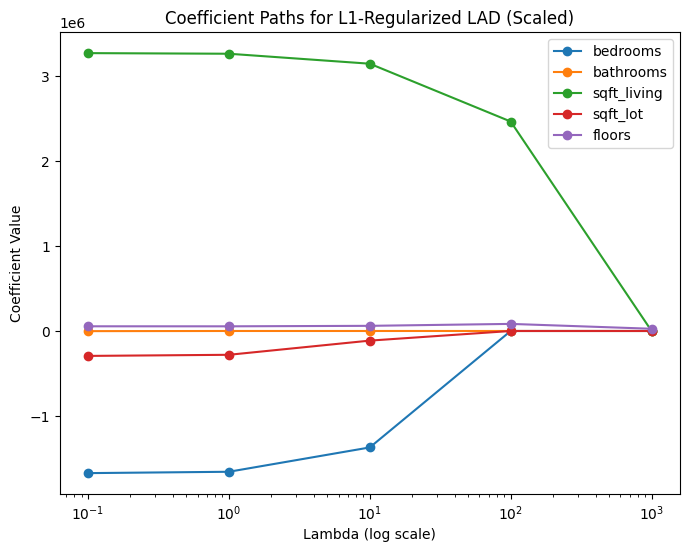

In [ ]:
!pip install -q pyomo
!apt-get install -y -qq coinor-cbc


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import (
    ConcreteModel, Var, RangeSet, Objective, ConstraintList,
    NonNegativeReals, minimize, SolverFactory, value
)


# load the MIN-MAX SCALE THE DATA
df = pd.read_csv("kc_house_data.csv")

features = ["bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors"]
mins, maxs = {}, {}
for f in features:
    mins[f] = df[f].min()
    maxs[f] = df[f].max()
    df[f+"_scaled"] = (df[f] - mins[f]) / (maxs[f] - mins[f])

print("Data loaded:", df.shape)
print("Scaled features:", [col for col in df.columns if col.endswith("_scaled")])


#  do the  L1-REGULARIZED LAD MODEL

def lad_l1_pyomo_scaled(df, lam):

    model = ConcreteModel()
    n = df.shape[0]
    model.I = RangeSet(0, n-1)

    # get the arrays
    y = df["price"].values
    x_bed = df["bedrooms_scaled"].values
    x_bath = df["bathrooms_scaled"].values
    x_sqft_living = df["sqft_living_scaled"].values
    x_sqft_lot = df["sqft_lot_scaled"].values
    x_floors = df["floors_scaled"].values

    # slack for LAD residuals
    model.ep = Var(model.I, within=NonNegativeReals)
    model.em = Var(model.I, within=NonNegativeReals)

    #  two nonnegative Vars for sign decomposition
    model.bed_pos = Var(within=NonNegativeReals)
    model.bed_neg = Var(within=NonNegativeReals)
    model.bath_pos = Var(within=NonNegativeReals)
    model.bath_neg = Var(within=NonNegativeReals)
    model.sqft_liv_pos = Var(within=NonNegativeReals)
    model.sqft_liv_neg = Var(within=NonNegativeReals)
    model.sqft_lot_pos = Var(within=NonNegativeReals)
    model.sqft_lot_neg = Var(within=NonNegativeReals)
    model.floors_pos = Var(within=NonNegativeReals)
    model.floors_neg = Var(within=NonNegativeReals)

    # Intercept for the modelb
    model.b = Var()

    #return Pyomo expressions for each net coefficient
    def beta_bed(m):
        return m.bed_pos - m.bed_neg
    def beta_bath(m):
        return m.bath_pos - m.bath_neg
    def beta_sqft_living(m):
        return m.sqft_liv_pos - m.sqft_liv_neg
    def beta_sqft_lot(m):
        return m.sqft_lot_pos - m.sqft_lot_neg
    def beta_floors(m):
        return m.floors_pos - m.floors_neg

    # constraints for each data point
    model.residuals = ConstraintList()
    for i_ in model.I:
        pred = (
            model.b
            + beta_bed(model)*x_bed[i_]
            + beta_bath(model)*x_bath[i_]
            + beta_sqft_living(model)*x_sqft_living[i_]
            + beta_sqft_lot(model)*x_sqft_lot[i_]
            + beta_floors(model)*x_floors[i_]
        )
        expr = y[i_] - pred
        model.residuals.add(model.ep[i_] - model.em[i_] == expr)

    # this is residuals + lam * sum_j (beta_pos_j + beta_neg_j)
    def obj_rule(m):
        resid_sum = sum(m.ep[i_] + m.em[i_] for i_ in m.I)
        reg_sum = (
            m.bed_pos + m.bed_neg
            + m.bath_pos + m.bath_neg
            + m.sqft_liv_pos + m.sqft_liv_neg
            + m.sqft_lot_pos + m.sqft_lot_neg
            + m.floors_pos + m.floors_neg
        )
        return resid_sum + lam * reg_sum

    model.obj = Objective(rule=obj_rule, sense=minimize)


    solver = SolverFactory("cbc")
    result = solver.solve(model, tee=False)

    #evaluate Pyomo expressions
    coefs_dict = {
        "b": value(model.b),
        "beta_bedrooms": value(beta_bed(model)),
        "beta_bathrooms": value(beta_bath(model)),
        "beta_sqft_living": value(beta_sqft_living(model)),
        "beta_sqft_lot": value(beta_sqft_lot(model)),
        "beta_floors": value(beta_floors(model))
    }
    return model, result, coefs_dict

lambda_values = [0.1, 1, 10, 100, 1000]
solutions = {}

for lam in lambda_values:
    model_l1, result_l1, coefs = lad_l1_pyomo_scaled(df, lam)
    print(f"\n========== λ = {lam} ==========")
    print("Solver status:", result_l1.solver.status)
    print("Termination condition:", result_l1.solver.termination_condition)

    for k, v in coefs.items():
        print(f"{k} = {v}")

    solutions[lam] = coefs


# solve the points

point1 = {"bedrooms": 4, "bathrooms": 3.5, "sqft_living": 3100, "sqft_lot": 12100, "floors": 2}
point2 = {"bedrooms": 2, "bathrooms": 2, "sqft_living": 1400, "sqft_lot": 16500, "floors": 1}

def scale_point(raw_dict, mins, maxs):
    return {
        f: (raw_dict[f] - mins[f]) / (maxs[f] - mins[f])
        for f in features
    }

p1_scaled = scale_point(point1, mins, maxs)
p2_scaled = scale_point(point2, mins, maxs)

def predict_price(coefs, sp):
    return (
        coefs["b"]
        + coefs["beta_bedrooms"]    * sp["bedrooms"]
        + coefs["beta_bathrooms"]   * sp["bathrooms"]
        + coefs["beta_sqft_living"] * sp["sqft_living"]
        + coefs["beta_sqft_lot"]    * sp["sqft_lot"]
        + coefs["beta_floors"]      * sp["floors"]
    )

for lam in lambda_values:
    coefs = solutions[lam]
    pred1 = predict_price(coefs, p1_scaled)
    pred2 = predict_price(coefs, p2_scaled)
    print(f"\nFor λ = {lam}:")
    print("  Point 1 Prediction:", pred1)
    print("  Point 2 Prediction:", pred2)

#plot lambda
lam_list = []
bed_list = []
bath_list = []
sqft_liv_list = []
sqft_lot_list = []
floors_list = []

for lam in lambda_values:
    lam_list.append(lam)
    coefs = solutions[lam]
    bed_list.append(coefs["beta_bedrooms"])
    bath_list.append(coefs["beta_bathrooms"])
    sqft_liv_list.append(coefs["beta_sqft_living"])
    sqft_lot_list.append(coefs["beta_sqft_lot"])
    floors_list.append(coefs["beta_floors"])

plt.figure(figsize=(8,6))
plt.plot(lam_list, bed_list, marker='o', label="bedrooms")
plt.plot(lam_list, bath_list, marker='o', label="bathrooms")
plt.plot(lam_list, sqft_liv_list, marker='o', label="sqft_living")
plt.plot(lam_list, sqft_lot_list, marker='o', label="sqft_lot")
plt.plot(lam_list, floors_list, marker='o', label="floors")

plt.xscale("log")
plt.xlabel("Lambda (log scale)")
plt.ylabel("Coefficient Value")
plt.title("Coefficient Paths for L1-Regularized LAD (Scaled)")
plt.legend()
plt.show()


When lamda is low the model is only weakly penalitized so this reault in the coeficients being larger.As Lamda grows the pentalty factor makes the coeficients to shrink.  When the lamda is at the highest the coeficients are dropping near 0.